<h1><center>Laboratorio 6: Optimización de modelos 🧪</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Francisco Maldonado
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** [Repositorio](https://github.com/FranMP999/)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from datetime import datetime
import joblib

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

from xgboost import XGBRegressor

RANDOM_STATE=99

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [4]:
df = pd.read_csv("sales.csv", index_col="id")
df.head()

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
id,,,,,,,,,,,
0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

### Split

In [5]:
from sklearn import set_config
set_config(transform_output="pandas")

def train_test_val_split(X, y,  val_size, test_size, stratify=None, random_state=None):
    if val_size >= 1:
        raise ("Tamaños de test y size no son válidos!")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size, stratify=stratify, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_size/(1-test_size), stratify=stratify, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


X = df.drop(columns="quantity")
y = df.quantity
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(
    X, y,
    val_size=0.2, test_size=0.1, random_state=RANDOM_STATE
)

### Preprocessing

In [6]:
numerical_columns = [
    "lat",
    "long",
    "price",
]
#Consideramos pop categórica por la poca cantidad de valores que presenta
#(en la práctica reduce el MAE igual)
categorical_columns = [
    "city",
    "shop",
    "brand",
    "pop",
    "container",
    "capacity",
    "day",
    "month",
    "year",
        ]
numeric_transformations = RobustScaler()
categorical_transformations = OneHotEncoder(
    sparse_output=False,
    handle_unknown='infrequent_if_exist'
)
column_transformer = ColumnTransformer([
    ('numerical', numeric_transformations, numerical_columns),
    ('categorical', categorical_transformations,  categorical_columns), 
    ], verbose_feature_names_out=False).set_output(transform='pandas')

#column_transformer.set_output(transform='pandas')

def date_processing(dataframe_in):
    return dataframe_in.assign(
            **dict(zip(
                ["day", "month", "year"],
                (lambda date_series: (
                    date_series.map(lambda x: x.day).astype("category"),
                    date_series.map(lambda x: x.month).astype("category"),
                    date_series.map(lambda x: x.year).astype("category"),
                    )
                    )(pd.to_datetime(df.date, format="%d/%m/%y"))
                ))
            )

### Dummy Pipeline

In [21]:
dummy_pipeline = Pipeline([
    ("date_preprocessing", FunctionTransformer(func=date_processing)),
    ("col_transformer", column_transformer),
    ("regressor", DummyRegressor(strategy='mean')),
])

y_predict_dummy = dummy_pipeline.fit(X_train, y_train).predict(X_val)
error_dummy = mean_absolute_error(y_predict_dummy, y_val)

In [23]:
print("MAE de DummyRegressor sobre el conjunto de validación: ", error_dummy)

MAE de DummyRegressor sobre el conjunto de validación:  13764.80958570919


### XGBoost Pipeline

In [22]:
xgb_pipeline = Pipeline([
    ("date_preprocessing", FunctionTransformer(func=date_processing)),
    ("col_transformer", column_transformer),
    ("regressor", XGBRegressor(seed=RANDOM_STATE)),
])

y_predict_xgb = xgb_pipeline.fit(X_train, y_train).predict(X_val)
error_xgb = mean_absolute_error(y_predict_xgb, y_val)

In [24]:
print("MAE de XGBoost sobre el conjunto de validación: ", error_xgb)

MAE de XGBoost sobre el conjunto de validación:  2444.2778390674744


In [9]:
joblib.dump(xgb_pipeline, 'trained_xgb_pipeline.pkl')
joblib.dump(dummy_pipeline, 'trained_dummy_pipeline.pkl')

['trained_dummy_pipeline.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [25]:
# Inserte su código acá
#xgb_pipeline["col_transformer"].get_feature_names_out()

xgb_mono_pipeline = Pipeline([
    ("date_preprocessing", FunctionTransformer(func=date_processing)),
    ("col_transformer", column_transformer),
    ("regressor", XGBRegressor(seed=RANDOM_STATE, monotone_constraints={'price':-1})),
])
y_predict_xgb_mono = xgb_mono_pipeline.fit(X_train, y_train).predict(X_val)
error_xgb_mono = mean_absolute_error(y_predict_xgb_mono, y_val)

In [26]:
print(
    f"Error validación sin restricción monótona: {error_xgb}\n"
    + f"Error validación con restricción monótona: {error_xgb_mono}"
        )

Error validación sin restricción monótona: 2444.2778390674744
Error validación con restricción monótona: 2475.9987414976226


## 3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [12]:
# Inserte su código acá

def objective(trial):
    # Inserte su código acá

    # Defininmos los hiperparámetros a tunear
    xgb_params = {
        "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
        "max_depth"    : trial.suggest_int("max_depth",    3, 10),
        "max_leaves"   : trial.suggest_int("max_leaves",   0, 100),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 5),
        "learning_rate" : trial.suggest_float("learning_rate", 0.001, 0.1),
        "reg_alpha"     : trial.suggest_float("reg_alpha",     0, 1),
        "reg_lambda"    : trial.suggest_float("reg_lambda",    0, 1),
    }
    ohe_params = {
        "min_frequency": trial.suggest_float("min_frequency", 0.0, 1.0)
    }

    # Creamos y entrenamos el pipeline
    column_transformer = ColumnTransformer([
        ('numerical', numeric_transformations, numerical_columns),
        (
            'categorical',
            OneHotEncoder( sparse_output=False, handle_unknown='infrequent_if_exist', **ohe_params) ,
            categorical_columns
            ), 
        ], verbose_feature_names_out=False)
    column_transformer.set_output(transform='pandas')

    trial_pipeline = Pipeline([
        ("date_preprocessing", FunctionTransformer(func=date_processing)),
        ("col_transformer", column_transformer),
        ("regressor", XGBRegressor(seed=RANDOM_STATE, **xgb_params)),
    ])
    trial_pipeline.fit(
        X_train, y_train,
    )
    #Guardamos el pipeline en el trial
    trial.set_user_attr("pipeline", trial_pipeline)

    # Obtenemos la predicción de validación
    yhat = trial_pipeline.predict(X_val)

    return mean_absolute_error(y_val, yhat)

study = optuna.create_study( direction="minimize")
study.optimize(objective, timeout=5*60)

In [13]:
print("Número de trials:", len(study.trials))
print("Mejor valor MAE:", study.best_trial.value)
print("Mejor hiperparámetros:", study.best_params)

Número de trials: 230
Mejor valor MAE: 1883.4297151539984
Mejor hiperparámetros: {'n_estimators': 898, 'max_depth': 10, 'max_leaves': 73, 'min_child_weight': 5, 'learning_rate': 0.09745323770770226, 'reg_alpha': 0.36444739884280053, 'reg_lambda': 0.4214963037276547, 'min_frequency': 0.0766512819191808}


In [14]:
joblib.dump(study.best_trial.user_attrs["pipeline"], 'trained_xgb_optuna_pipeline.pkl')

['trained_xgb_optuna_pipeline.pkl']

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [15]:
#!pip install optuna-integration[xgboost]

In [16]:
# Inserte su código acá
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    # Inserte su código acá

    # Defininmos los hiperparámetros a tunear
    xgb_params = {
        "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
        "max_depth"    : trial.suggest_int("max_depth",    3, 10),
        "max_leaves"   : trial.suggest_int("max_leaves",   0, 100),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 5),
        "learning_rate" : trial.suggest_float("learning_rate", 0.001, 0.1),
        "reg_alpha"     : trial.suggest_float("reg_alpha",     0, 1),
        "reg_lambda"    : trial.suggest_float("reg_lambda",    0, 1),
    }
    ohe_params = {
        "min_frequency": trial.suggest_float("min_frequency", 0.0, 1.0)
    }

    # Creamos y entrenamos el pipeline
    preprocessing_pipeline = Pipeline([
        ("date_preprocessing", FunctionTransformer(func=date_processing)),
        (
            "col_transformer",
            ColumnTransformer([
            ('numerical', numeric_transformations, numerical_columns),
            (
                'categorical', 
                OneHotEncoder( 
                    sparse_output=False,
                    handle_unknown='infrequent_if_exist',
                    **ohe_params),
                categorical_columns
                ) 
            ] , verbose_feature_names_out=False).set_output(transform='pandas')
        ),
    ])
    trial_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("regressor", XGBRegressor(
            seed=RANDOM_STATE,
            early_stopping_rounds=10,
            callbacks=[ optuna.integration.XGBoostPruningCallback(
                trial, observation_key="validation_1-rmse"
                )],
            **xgb_params)),
    ])
    trial_pipeline["preprocessing"].fit(X_train)
    eval_set =     trial_pipeline["regressor"].fit(
        trial_pipeline["preprocessing"].transform(X_train),
        y_train,
        eval_set= [
            (trial_pipeline["preprocessing"].transform(X_train), y_train),
            (trial_pipeline["preprocessing"].transform(X_val),y_val)
            ],

    )
    #Guardamos el pipeline en el trial
    trial.set_user_attr("pipeline", trial_pipeline)

    # Obtenemos la predicción de validación
    yhat = trial_pipeline.predict(X_val)

    return mean_absolute_error(y_val, yhat)

study_prunning = optuna.create_study( direction="minimize")
study_prunning.optimize(objective, timeout=5*60)

[0]	validation_0-rmse:17002.04481	validation_1-rmse:17353.53662
[1]	validation_0-rmse:16497.51355	validation_1-rmse:16849.59511
[2]	validation_0-rmse:16034.56511	validation_1-rmse:16390.15291
[3]	validation_0-rmse:15609.45321	validation_1-rmse:15960.84729
[4]	validation_0-rmse:15215.71890	validation_1-rmse:15561.77665
[5]	validation_0-rmse:14857.11698	validation_1-rmse:15207.32930
[6]	validation_0-rmse:14526.54348	validation_1-rmse:14876.21760
[7]	validation_0-rmse:14222.24069	validation_1-rmse:14577.70831
[8]	validation_0-rmse:13943.75430	validation_1-rmse:14299.99056
[9]	validation_0-rmse:13686.49841	validation_1-rmse:14038.91159
[10]	validation_0-rmse:13451.85113	validation_1-rmse:13807.93378
[11]	validation_0-rmse:13235.90301	validation_1-rmse:13597.16542
[12]	validation_0-rmse:13038.21723	validation_1-rmse:13404.71197
[13]	validation_0-rmse:12856.98927	validation_1-rmse:13227.32881
[14]	validation_0-rmse:12692.60743	validation_1-rmse:13069.68737
[15]	validation_0-rmse:12542.47671	

In [17]:
print("Número de trials:", len(study_prunning.trials))
print("Mejor valor MAE:", study_prunning.best_trial.value)
print("Mejor hiperparámetros:", study_prunning.best_params)

Número de trials: 79
Mejor valor MAE: 2059.8465707078376
Mejor hiperparámetros: {'n_estimators': 469, 'max_depth': 9, 'max_leaves': 0, 'min_child_weight': 4, 'learning_rate': 0.09950048136053562, 'reg_alpha': 0.8919832009584807, 'reg_lambda': 0.4585510800135575, 'min_frequency': 0.06904870302389488}


In [18]:
joblib.dump(
    study_prunning.best_trial.user_attrs["pipeline"],
    'trained_xgb_optuna_prunning_pipeline.pkl'
)

['trained_xgb_optuna_prunning_pipeline.pkl']

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

In [28]:
# Inserte su código acá
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances


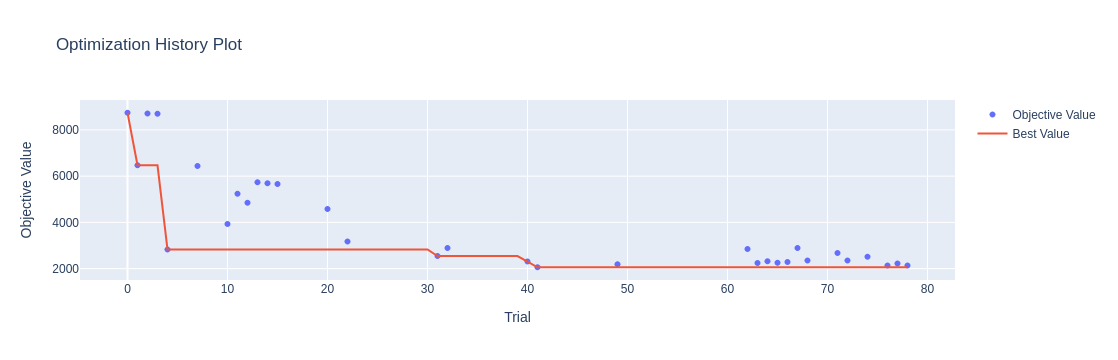

In [37]:
plot_optimization_history(study_prunning)

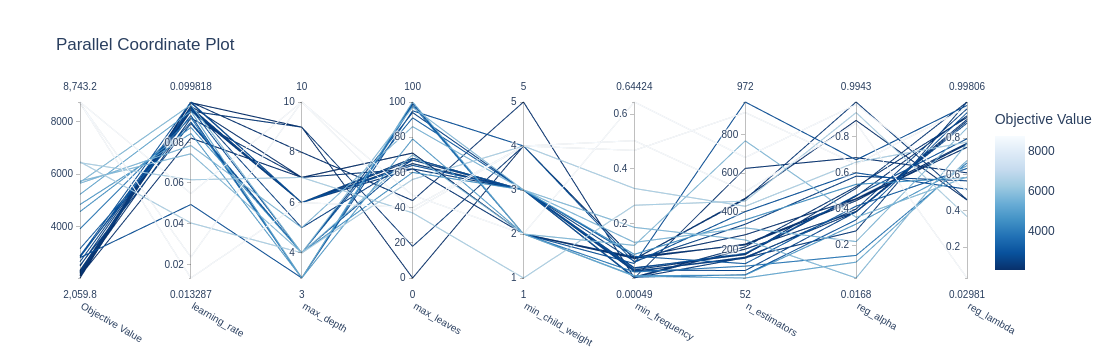

In [36]:
plot_parallel_coordinate(study_prunning)

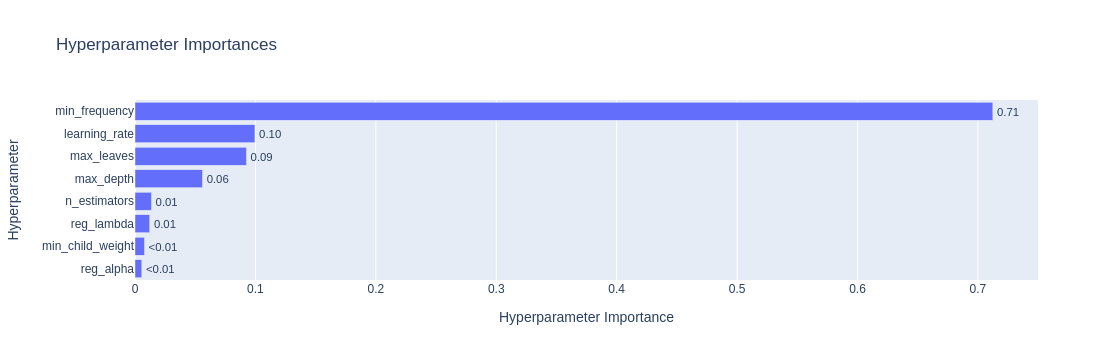

In [35]:
plot_param_importances(study_prunning)

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [41]:
# Inserte su código acá
display(pd.DataFrame({
    "Model": [
        "Dummy",
        "Base XGBoost",
        "Constrained",
        "XGBoost-Optuna",
        "XGBoost-Optuna-Prunning"
    ],
    "MAE": [
        error_dummy,
        error_xgb,
        error_xgb_mono,
        study.best_trial.value,
        study_prunning.best_trial.value
    ],
}).set_index("Model"))

,MAE
Model,
Dummy,13764.809586
Base XGBoost,2444.277839
Constrained,2475.998741
XGBoost-Optuna,1883.429715
XGBoost-Optuna-Prunning,2059.846571


In [42]:
model = study.best_trial.user_attrs["pipeline"]
y_pred = model.predict(X_test)
test_error = mean_absolute_error(y_test, y_pred)

In [43]:
test_error

np.float64(1852.3811427875753)

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>